In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import random
import pickle
import joblib 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [ ]:
data_paths = "/content/drive/My Drive/data"
experiment_path = "/content/drive/My Drive/dest_data"
with_mask_path =  "/content/drive/My Drive/data/with_mask"
without_mask_path = "/content/drive/My Drive/data/without_mask"

In [ ]:
labels = []
training_labels = []
test_labels = []
training_images = []
testing_images =[]


In [ ]:
imagePaths = list(paths.list_images(data_paths))
data = []
labels = []
random.shuffle(imagePaths)
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]
	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)
	data.append(image)
	labels.append(label)

	
	
	
 
print(labels[:5])

['with_mask', 'without_mask', 'without_mask', 'without_mask', 'without_mask']


In [ ]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [ ]:
print(np.shape(labels))

(1376, 2)


In [ ]:
(training_images, testing_images, training_labels, testing_labels) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

In [ ]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")


In [ ]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [ ]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(training_images, training_labels, batch_size=BS),
	steps_per_epoch=len(training_images) // BS,
	validation_data=(testing_images, testing_labels),
	validation_steps=len(testing_images) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
34/34 [==============================] - 52s 2s/step - loss: 0.2362 - accuracy: 0.9082 - val_loss: 0.0689 - val_accuracy: 0.9819
Epoch 2/20
34/34 [==============================] - 51s 1s/step - loss: 0.0959 - accuracy: 0.9710 - val_loss: 0.0439 - val_accuracy: 0.9891
Epoch 3/20
34/34 [==============================] - 51s 1s/step - loss: 0.0621 - accuracy: 0.9813 - val_loss: 0.0317 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 51s 2s/step - loss: 0.0506 - accuracy: 0.9869 - val_loss: 0.0330 - val_accuracy: 0.9819
Epoch 5/20
34/34 [==============================] - 51s 1s/step - loss: 0.0422 - accuracy: 0.9850 - val_loss: 0.0223 - val_accuracy: 0.9928
Epoch 6/20
34/34 [==============================] - 51s 1s/step - loss: 0.0319 - accuracy: 0.9888 - val_loss: 0.0171 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 51s 1s/step - loss: 0.0219 - accuracy: 0.9963 - val_loss: 0.0192 - val_accuracy: 0.9

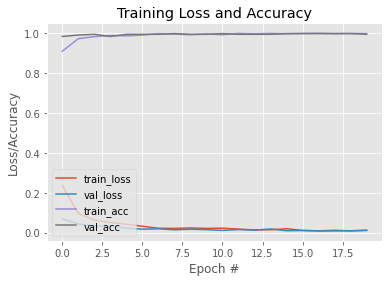

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testing_images, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testing_labels.argmax(axis=1), predIdxs,
	target_names=lb.classes_))
# serialize the model to disk
print("[INFO] saving mask detector model...")

[INFO] evaluating network...
              precision    recall  f1-score   support

   with_mask       1.00      0.99      0.99       138
without_mask       0.99      1.00      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276

[INFO] saving mask detector model...


    '''punctuations = ['!', ',' , '&', '.' , '(' , ')' , ':' , ';' , '@' , '#' , '%' , '^' , '*' , '"' , '[' , ']', '/' , '\', ]'''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    i = ''.join(word for word in i if word not in punctuations)

In [ ]:
print(type(model))
model.save("/content/drive/My Drive/trained_model.h5", save_format="h5")



<class 'tensorflow.python.keras.engine.training.Model'>


In [ ]:
saved_model = load_model("/content/drive/My Drive/trained_model.h5")
saved_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________